# Runoff

see model-agnostic tutorial:
https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/Model_Agnostic_Analysis.ipynb

In [1]:
%matplotlib inline
import intake
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import cftime
import xgcm

import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft

from dask.distributed import Client

In [2]:
xr.set_options(keep_attrs=True); # cf_xarray works best when xarray keeps attributes by default

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33171,Workers: 14
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:42739,Total threads: 1
Dashboard: /proxy/41535/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:36581,


## JRA55do data

Need access to `gdata/qv56` and `gdata/vk83`

#### RYF data

from [`config.yaml`](https://github.com/ACCESS-NRI/access-om3-configs/blob/dev-1deg_jra55do_ryf/config.yaml#L35C7-L35C62) and[`drof.streams.xml`](https://github.com/ACCESS-NRI/access-om3-configs/blob/dev-1deg_jra55do_ryf/drof.streams.xml)
- `/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.friver.1990_1991.nc`
- `/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.licalvf.1990_1991.nc`

#### IAF data
from [`config.yaml`](https://github.com/ACCESS-NRI/access-om3-configs/blob/dev-1deg_jra55do_iaf/config.yaml) and[`drof.streams.xml`](https://github.com/ACCESS-NRI/access-om3-configs/blob/dev-1deg_jra55do_iaf/drof.streams.xml)
- `/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/land/day/friver/gr/v20190429/friver_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_*.nc`
- `/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/landIce/day/licalvf/gr/v20190429/licalvf_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_*.nc`

#### Cell areas (`areacello`)
`/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/ocean/fx/areacello/gr/v20190429/areacello_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr.nc`

In [4]:
jra55dopaths = {
    'areacello': '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/ocean/fx/areacello/gr/v20190429/areacello_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr.nc',
    'friver': '/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.friver.1990_1991.nc',
    'licalvf': '/g/data/vk83/configurations/inputs/JRA-55/RYF/v1-4/data/RYF.licalvf.1990_1991.nc'
}

In [5]:
jra55do = xr.open_mfdataset([ v for v in jra55dopaths.values() ])

In [6]:
jra55do

<xarray.Dataset> Size: 3GB
Dimensions:    (lat: 720, bnds: 2, lon: 1440, time: 365)
Coordinates:
  * lat        (lat) float64 6kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon        (lon) float64 12kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time       (time) object 3kB 1900-01-01 00:00:00 ... 1900-12-31 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 12kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 23kB dask.array<chunksize=(1440, 2), meta=np.ndarray>
    areacello  (lat, lon) float32 4MB dask.array<chunksize=(720, 1440), meta=np.ndarray>
    friver     (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    licalvf    (time, lat, lon) float32 2GB dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
Attributes: (12/34)
    Conventions:         CF-1.7 CMIP-6.2
    activity_id:         input4MIPs
    comment:             Based on JRA-55 reanalysis (1958-01 to 2019-01)
    contact:             Hiroyuki Tsujino (htsujino@mri-jma.go.jp)
    creation_date:       2019-03-08T11:48:52Z
    data_specs_version:  01.00.29
    ...                  ...
    target_mip:          OMIP
    title:               MRI JRA55-do 1.4.0 dataset prepared for input4MIPs
    tracking_id:         hdl:21.14100/29996f42-a99e-4762-8f11-24888d857e61
    variable_id:         areacello
    license:             OMIP boundary condition data produced by MRI is lice...
    cmor_version:        3.4.0

In [7]:
jra55doGrid = xgcm.Grid(jra55do,
                        periodic=['X'],
                        metrics = { ('X', 'Y'): ['areacello']})

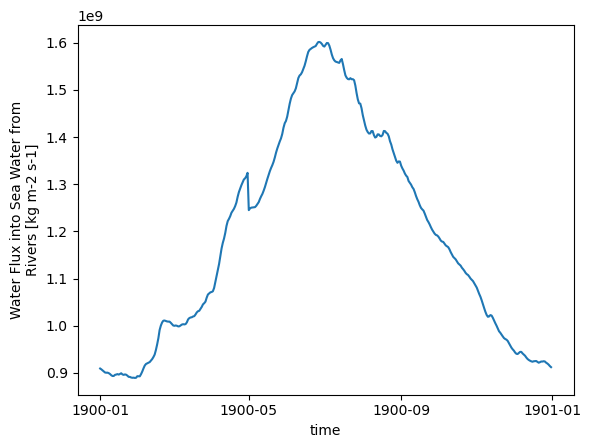

In [8]:
jra55doGrid.integrate(jra55do.friver, ['X', 'Y']).plot()

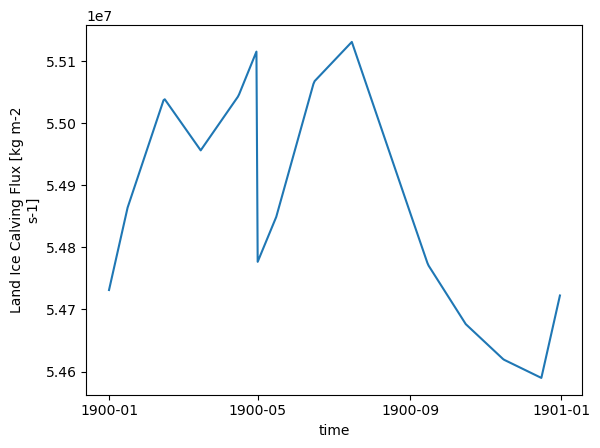

In [9]:
jra55doGrid.integrate(jra55do.licalvf, ['X', 'Y']).plot()

## ACCESS-OM3 data
`access-om3.mom6.h.native_1900_01.nc` contains
```
	float total_frunoff(time, scalar_axis) ;
		total_frunoff:units = "kg s-1" ;
		total_frunoff:long_name = "Area integrated frozen runoff (calving) & iceberg melt into ocean" ;
		total_frunoff:cell_methods = "time: mean" ;
	float total_lrunoff(time, scalar_axis) ;
		total_lrunoff:units = "kg s-1" ;
		total_lrunoff:long_name = "Area integrated liquid runoff into ocean" ;
		total_lrunoff:cell_methods = "time: mean" ;
	float friver(time, yh, xh) ;
		friver:units = "kg m-2 s-1" ;
		friver:long_name = "Water Flux into Sea Water From Rivers" ;
		friver:cell_methods = "area:mean yh:mean xh:mean time: mean" ;
		friver:cell_measures = "area: areacello" ;
		friver:standard_name = "water_flux_into_sea_water_from_rivers" ;
	float ficeberg(time, yh, xh) ;
		ficeberg:units = "kg m-2 s-1" ;
		ficeberg:long_name = "Water Flux into Seawater from Icebergs" ;
		ficeberg:cell_methods = "area:mean yh:mean xh:mean time: mean" ;
		ficeberg:cell_measures = "area: areacello" ;
		ficeberg:standard_name = "water_flux_into_sea_water_from_icebergs" ;
		total_frunoff:long_name = "Area integrated frozen runoff (calving) & iceberg melt into ocean" ;
	float net_massin(time, yh, xh) ;
		net_massin:units = "kg m-2 s-1" ;
		net_massin:long_name = "Net mass entering ocean due to precip, runoff, ice melt" ;
		net_massin:cell_methods = "area:mean yh:mean xh:mean time: mean" ;
		net_massin:cell_measures = "area: areacello" ;
	float net_massout(time, yh, xh) ;
		net_massout:units = "kg m-2 s-1" ;
		net_massout:long_name = "Net mass leaving the ocean due to evaporation, seaice formation" ;
		net_massout:cell_methods = "area:mean yh:mean xh:mean time: mean" ;
		net_massout:cell_measures = "area: areacello" ;
	float masso(time, scalar_axis) ;
		masso:units = "kg" ;
		masso:long_name = "Mass of liquid ocean" ;
		masso:cell_methods = "time: mean" ;
		masso:standard_name = "sea_water_mass" ;
```

In [10]:
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.iss138/'
# PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.testAug2024/'
PATH='/scratch/v45/aek156/access-om3/archive/MOM6-CICE6-1deg_jra55do_ryf.runoff/'

In [11]:
# from https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
# Try passing the following argument to your to_dask or to_dataset_dict call:
# See the xarray documentation on Reading multi-file datasets for more details about these arguments.
# https://docs.xarray.dev/en/stable/user-guide/io.html#reading-multi-file-datasets

xarray_combine_by_coords_kwargs=dict(
    compat="override",
    data_vars="minimal",
    coords="minimal"
)

In [12]:
# datastore = intake.open_esm_datastore(PATH+'intake_datastore.json', columns_with_iterables=['variable'])
datastore = intake.open_esm_datastore(PATH+'intake_esm_ds.json', columns_with_iterables=['variable'])

In [13]:
datastore.df

,path,realm,variable,frequency,start_date,end_date,variable_long_name,variable_standard_name,variable_cell_methods,variable_units,filename,file_id
0,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa...",1day,"1900-01-01, 00:00:00","1900-02-01, 00:00:00","['time interval endpoints', 'category maximum ...","['', '', '', '', '', '', '', '', '', '', '', '...","['time: mean', '', '', '', '', '', '', '', '',...","['days since 1900-01-01 00:00:00', 'm', '1', '...",access-om3.cice.1900-01.nc,access_om3_cice_XXXX_XX
1,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa...",1day,"1900-02-01, 00:00:00","1900-03-01, 00:00:00","['time interval endpoints', 'category maximum ...","['', '', '', '', '', '', '', '', '', '', '', '...","['time: mean', '', '', '', '', '', '', '', '',...","['days since 1900-01-01 00:00:00', 'm', '1', '...",access-om3.cice.1900-02.nc,access_om3_cice_XXXX_XX
2,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa...",1day,"1900-03-01, 00:00:00","1900-04-01, 00:00:00","['time interval endpoints', 'category maximum ...","['', '', '', '', '', '', '', '', '', '', '', '...","['time: mean', '', '', '', '', '', '', '', '',...","['days since 1900-01-01 00:00:00', 'm', '1', '...",access-om3.cice.1900-03.nc,access_om3_cice_XXXX_XX
3,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa...",1day,"1900-04-01, 00:00:00","1900-05-01, 00:00:00","['time interval endpoints', 'category maximum ...","['', '', '', '', '', '', '', '', '', '', '', '...","['time: mean', '', '', '', '', '', '', '', '',...","['days since 1900-01-01 00:00:00', 'm', '1', '...",access-om3.cice.1900-04.nc,access_om3_cice_XXXX_XX
4,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,seaIce,"[time_bounds, NCAT, VGRDi, VGRDs, VGRDb, VGRDa...",1day,"1900-05-01, 00:00:00","1900-06-01, 00:00:00","['time interval endpoints', 'category maximum ...","['', '', '', '', '', '', '', '', '', '', '', '...","['time: mean', '', '', '', '', '', '', '', '',...","['days since 1900-01-01 00:00:00', 'm', '1', '...",access-om3.cice.1900-05.nc,access_om3_cice_XXXX_XX
...,...,...,...,...,...,...,...,...,...,...,...,...
92,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[uo, vo, KE, h, thetao, so, agessc, rhopot0, v...",1mon,"1900-08-01, 00:00:00","1900-09-01, 00:00:00","['Sea Water X Velocity', 'Sea Water Y Velocity...","['sea_water_x_velocity', 'sea_water_y_velocity...","['z_l:mean yh:mean xq:point time: mean', 'z_l:...","['m s-1', 'm s-1', 'm2 s-2', 'm', 'degC', 'psu...",access-om3.mom6.h.z1900_08.nc,access_om3_mom6_h_zXXXX_XX
93,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[uo, vo, KE, h, thetao, so, agessc, rhopot0, v...",1mon,"1900-09-01, 00:00:00","1900-10-01, 00:00:00","['Sea Water X Velocity', 'Sea Water Y Velocity...","['sea_water_x_velocity', 'sea_water_y_velocity...","['z_l:mean yh:mean xq:point time: mean', 'z_l:...","['m s-1', 'm s-1', 'm2 s-2', 'm', 'degC', 'psu...",access-om3.mom6.h.z1900_09.nc,access_om3_mom6_h_zXXXX_XX
94,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[uo, vo, KE, h, thetao, so, agessc, rhopot0, v...",1mon,"1900-10-01, 00:00:00","1900-11-01, 00:00:00","['Sea Water X Velocity', 'Sea Water Y Velocity...","['sea_water_x_velocity', 'sea_water_y_velocity...","['z_l:mean yh:mean xq:point time: mean', 'z_l:...","['m s-1', 'm s-1', 'm2 s-2', 'm', 'degC', 'psu...",access-om3.mom6.h.z1900_10.nc,access_om3_mom6_h_zXXXX_XX
95,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[uo, vo, KE, h, thetao, so, agessc, rhopot0, v...",1mon,"1900-11-01, 00:00:00","1900-12-01, 00:00:00","['Sea Water X Velocity', 'Sea Water Y Velocity...","['sea_water_x_velocity', 'sea_water_y_velocity...","['z_l:mean yh:mean xq:point time: mean', 'z_l:...","['m s-1', 'm s-1', 'm2 s-2', 'm', 'degC', 'psu...",access-om3.mom6.h.z1900_11.nc,access_om3_mom6

In [14]:
datastore.search(path='.*access-om3\.mom6\.h\.native.*',
                 frequency='1day').df.head()

,path,realm,variable,frequency,start_date,end_date,variable_long_name,variable_standard_name,variable_cell_methods,variable_units,filename,file_id
0,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-01-01, 00:00:00","1900-02-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_01.nc,access_om3_mom6_h_native_dailyXXXX_XX
1,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-02-01, 00:00:00","1900-03-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_02.nc,access_om3_mom6_h_native_dailyXXXX_XX
2,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-03-01, 00:00:00","1900-04-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_03.nc,access_om3_mom6_h_native_dailyXXXX_XX
3,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-04-01, 00:00:00","1900-05-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_04.nc,access_om3_mom6_h_native_dailyXXXX_XX
4,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-05-01, 00:00:00","1900-06-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_05.nc,access_om3_mom6_h_native_dailyXXXX_XX


In [15]:
datastore.search(path='.*access-om3\.mom6\.h\.native.*',
                 frequency='1day').df.head()['variable_cell_methods'][0]

"['area:mean yh:mean xh:mean time: mean', 'area:mean yh:mean xh:mean time: mean', 'time: mean', 'time: mean', '', '', '', '']"

In [16]:
datastore.search(path='.*access-om3\.mom6\.h\.native.*',
                 frequency='1day',
                 variable_cell_methods='.*time: mean.*')

,unique
path,12
realm,1
variable,8
frequency,1
start_date,12
end_date,12
variable_long_name,1
variable_standard_name,1
variable_cell_methods,1
variable_units,1


In [17]:
# see https://github.com/COSIMA/cosima-recipes/blob/main/Tutorials/ACCESS-NRI_Intake_Catalog.ipynb
static = datastore.search(path='.*output000.*',
                          frequency='fx'
                         ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)

In [18]:
areacello = static['areacello']

see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition

ACCESS-OM3 uses a non-symmetric memory layout, i.e. all fields have the same i and j sizes. See
https://mom6.readthedocs.io/en/main/api/generated/pages/Horizontal_Indexing.html?highlight=symmetric#declaration-of-variables

`MOM_parameter_doc.layout`:
```
!SYMMETRIC_MEMORY_ = False      !   [Boolean]
                                ! If defined, the velocity point data domain includes every face of the
                                ! thickness points. In other words, some arrays are larger than others,
                                ! depending on where they are on the staggered grid.  Also, the starting index
                                ! of the velocity-point arrays is usually 0, not 1. This can only be set at
                                ! compile time.```


In [19]:
# for non-symmetric 
# SYMMETRIC_MEMORY_ = False
# see https://xgcm.readthedocs.io/en/latest/xgcm-examples/03_MOM6.html#xgcm-grid-definition
# and https://xgcm.readthedocs.io/en/latest/grid_metrics.html#Using-metrics-with-xgcm
grid = xgcm.Grid(static,
                 coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'right': 'yq'},},
                         # 'Z': { 'inner': 'zl', 'outer': 'zi'}},
                 metrics = {
                        ('X',): ['dxt', 'dxCu', 'dxCv'], # X distances
                        ('Y',): ['dyt', 'dyCu', 'dyCv'], # Y distances
                        ('X', 'Y'): ['areacello', 'areacello_cu', 'areacello_cv', 'areacello_bu'] # Areas
                        },
                 periodic=['X'])

In [20]:
datastore.search(path='.*access-om3\.mom6\.h\.native.*',
                          frequency='1day',
                          variable_cell_methods='.*time: mean.*'
                         ).to_dask(xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs)

<xarray.Dataset> Size: 315MB
Dimensions:        (time: 365, yh: 300, xh: 360, scalar_axis: 1, nv: 2)
Coordinates:
  * xh             (xh) float64 3kB -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * yh             (yh) float64 2kB -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time           (time) object 3kB 1900-01-01 12:00:00 ... 1900-12-31 12:00:00
  * nv             (nv) float64 16B 1.0 2.0
  * scalar_axis    (scalar_axis) float64 8B 0.0
Data variables:
    friver         (time, yh, xh) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ficeberg       (time, yh, xh) float32 158MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    total_frunoff  (time, scalar_axis) float32 1kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    total_lrunoff  (time, scalar_axis) float32 1kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    average_T1     (time) datetime64[ns] 3kB dask.array<chunksize=(31,), meta=np.ndarray>
    average_T2     (time) datetime64[ns] 3kB dask.array<chunksize=(31,), meta=np.ndarray>
    average_DT     (time) timedelta64[ns] 3kB dask.array<chunksize=(31,), meta=np.ndarray>
    time_bnds      (time, nv) object 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    MOM6 diagnostic fields table
    associated_files:                         areacello: access-om3.mom6.h.st...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['friver', 'ficeberg', 'total_f...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ['water_flux_into_sea_water_fro...
    intake_esm_attrs:variable_cell_methods:   ['area:mean yh:mean xh:mean tim...
    intake_esm_attrs:variable_units:          ['kg m-2 s-1', 'kg m-2 s-1', 'k...
    intake_esm_attrs:file_id:                 access_om3_mom6_h_native_dailyX...
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_h_native_dailyX...

In [21]:
datastore.search(variable='friver', frequency='1day').df.head()

,path,realm,variable,frequency,start_date,end_date,variable_long_name,variable_standard_name,variable_cell_methods,variable_units,filename,file_id
0,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-01-01, 00:00:00","1900-02-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_01.nc,access_om3_mom6_h_native_dailyXXXX_XX
1,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-02-01, 00:00:00","1900-03-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_02.nc,access_om3_mom6_h_native_dailyXXXX_XX
2,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-03-01, 00:00:00","1900-04-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_03.nc,access_om3_mom6_h_native_dailyXXXX_XX
3,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-04-01, 00:00:00","1900-05-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_04.nc,access_om3_mom6_h_native_dailyXXXX_XX
4,/home/156/aek156/payu/MOM6-CICE6-1deg_jra55do_...,ocean,"[friver, ficeberg, total_frunoff, total_lrunof...",1day,"1900-05-01, 00:00:00","1900-06-01, 00:00:00","['Water Flux into Sea Water From Rivers', 'Wat...","['water_flux_into_sea_water_from_rivers', 'wat...","['area:mean yh:mean xh:mean time: mean', 'area...","['kg m-2 s-1', 'kg m-2 s-1', 'kg s-1', 'kg s-1...",access-om3.mom6.h.native_daily1900_05.nc,access_om3_mom6_h_native_dailyXXXX_XX


In [22]:
fields = ['total_lrunoff', 'friver', 'total_frunoff', 'ficeberg',
          # 'net_massin', 'net_massout', 'masso'
         ]
data = { k: datastore.search(variable=k, frequency='1day', variable_cell_methods='.*time: mean.*').to_dask(
    xarray_combine_by_coords_kwargs=xarray_combine_by_coords_kwargs) for k in fields }

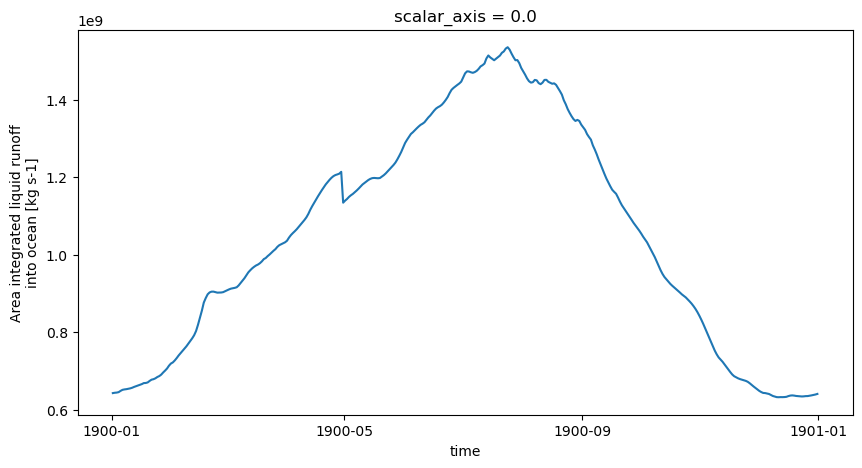

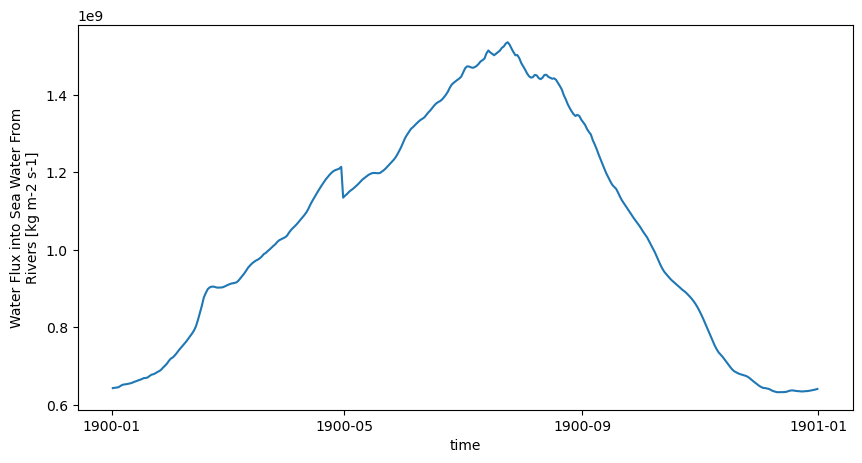

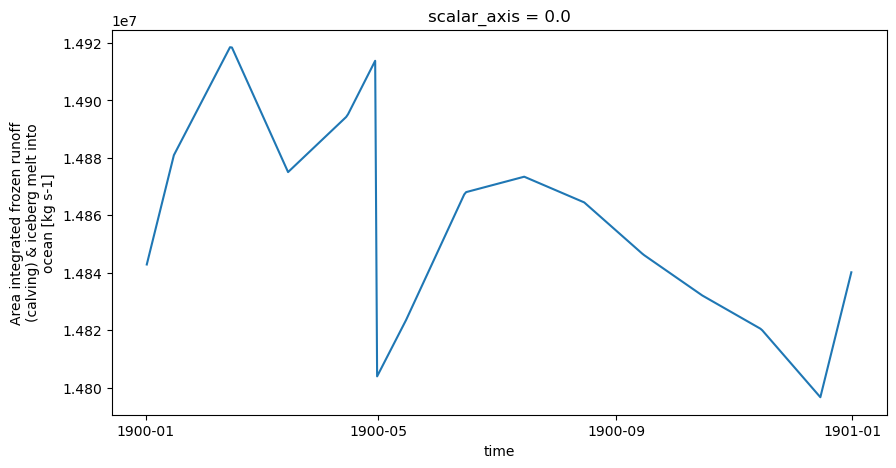

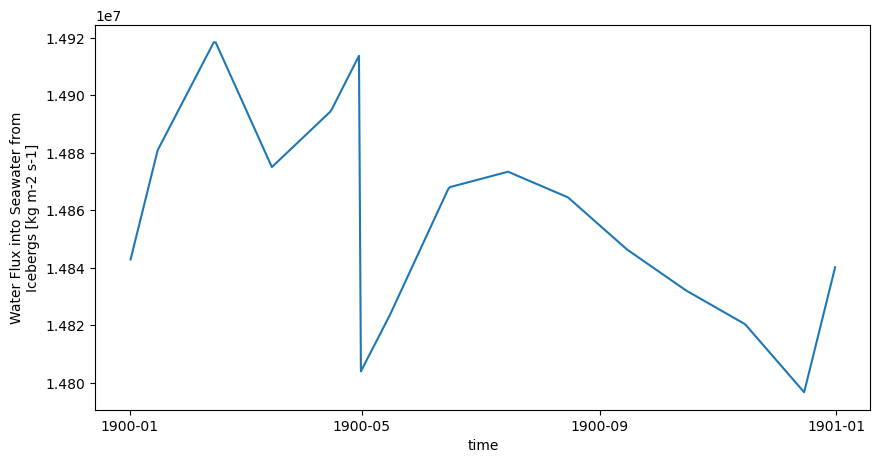

In [23]:
for k, d in data.items():
    plt.figure(figsize=(10,5))
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.integrate(dat, ['X', 'Y', 'Z'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.integrate(dat, ['X', 'Y'])
    dat.load()
    dat.plot()
    # dat.cf.resample(time='1YE').mean('time').plot()
    # dat.cf.rolling(time=365, center=True).mean('time').plot()

## Comparing JRA55do inputs with MOM6 outputs

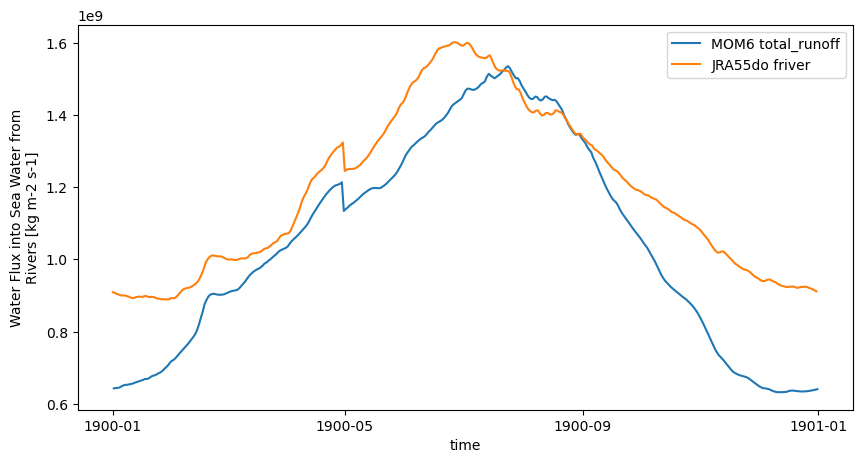

In [24]:
plt.figure(figsize=(10,5))
data['total_lrunoff']['total_lrunoff'].plot(label='MOM6 total_runoff')
jra55doGrid.integrate(jra55do.friver, ['X', 'Y']).plot(label='JRA55do friver')
plt.legend()

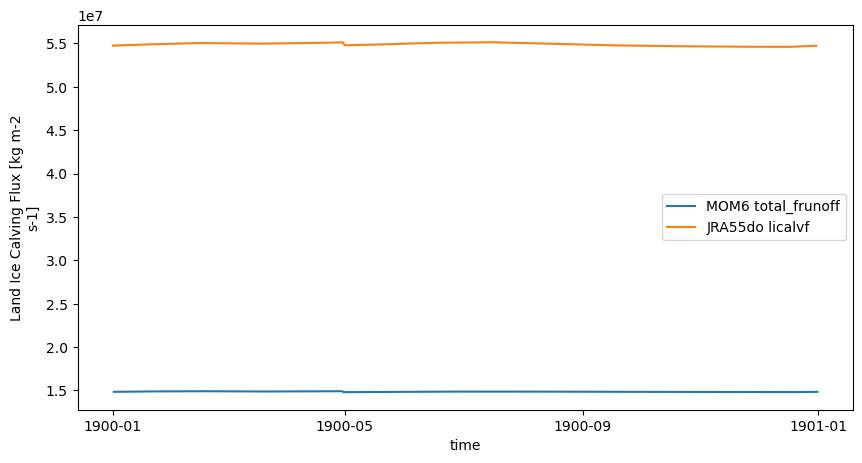

In [25]:
plt.figure(figsize=(10,5))
data['total_frunoff']['total_frunoff'].plot(label='MOM6 total_frunoff')
jra55doGrid.integrate(jra55do.licalvf, ['X', 'Y']).plot(label='JRA55do licalvf')
plt.legend()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


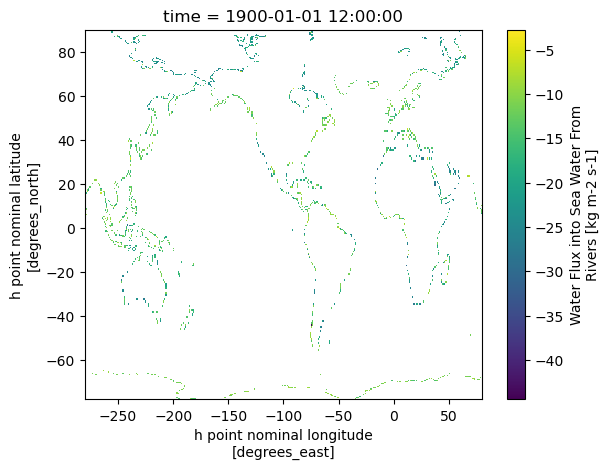

In [26]:
# NB: missing Black Sea!

np.log(data['friver']['friver'].isel(time=0)).plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


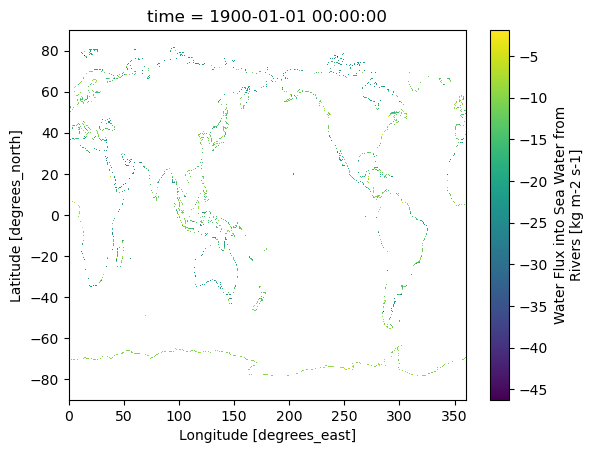

In [27]:
np.log(jra55do.friver.isel(time=0)).plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


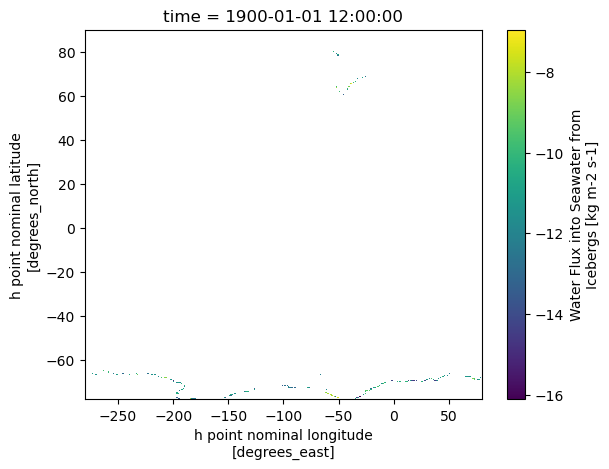

In [28]:
np.log(data['ficeberg']['ficeberg'].isel(time=0)).plot()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


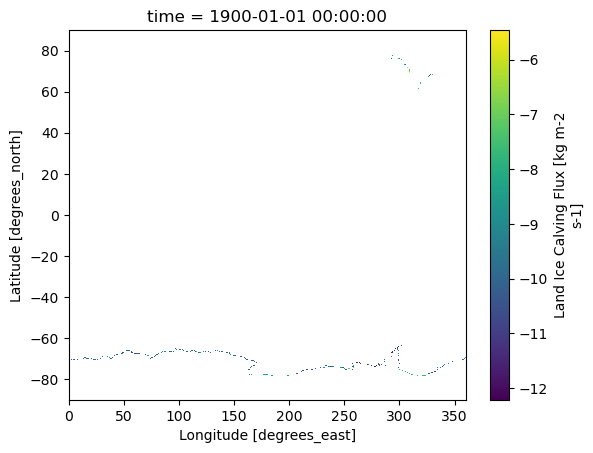

In [29]:
np.log(jra55do.licalvf.isel(time=0)).plot()

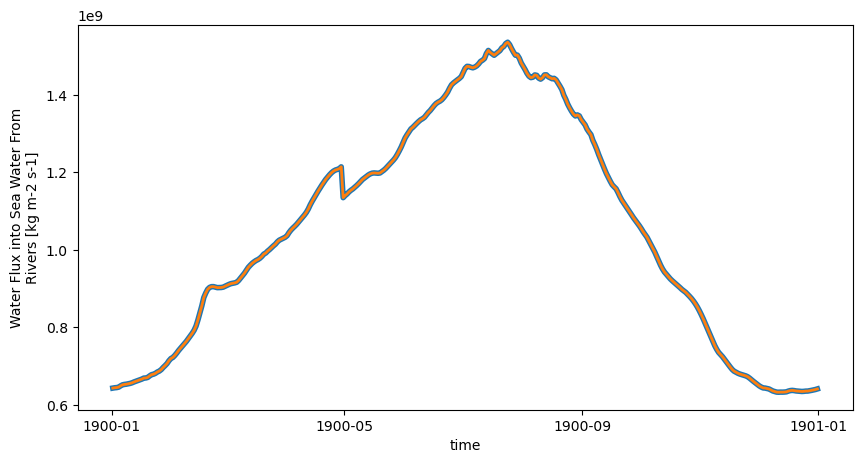

In [30]:
# check area-integral of friver equals total_lrunoff
plt.figure(figsize=(10,5))
for i, (k, d) in enumerate({ k: data[k] for k in ['total_lrunoff', 'friver'] }.items()):
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.integrate(dat, ['X', 'Y', 'Z'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.integrate(dat, ['X', 'Y'])
    dat.load()
    dat.plot(linewidth=2*(2-i))

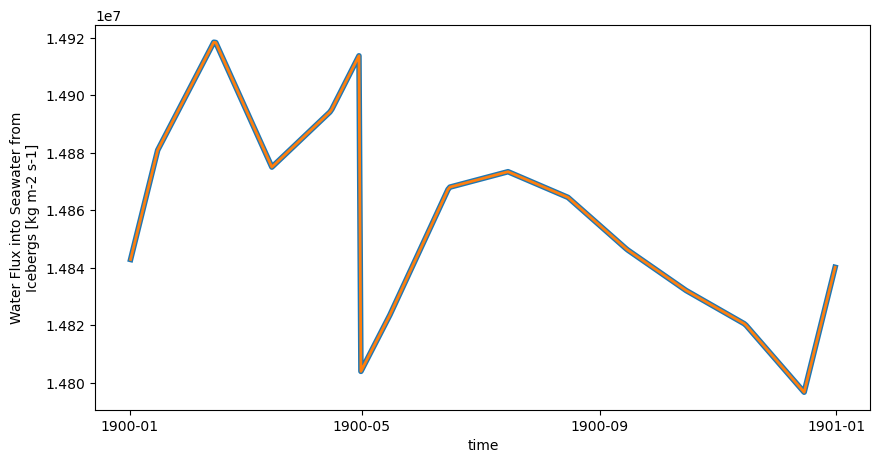

In [31]:
# check area-integral of ficeberg equals total_frunoff
plt.figure(figsize=(10,5))
for i, (k, d) in enumerate({ k: data[k] for k in ['total_frunoff', 'ficeberg'] }.items()):
    dat = d[k]
    if 'depth' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.integrate(dat, ['X', 'Y', 'Z'])
    elif 'longitude' in dat.cf.coords: # https://xgcm.readthedocs.io/en/latest/grid_metrics.html?highlight=average#Grid-aware-(weighted)-average
        dat = grid.integrate(dat, ['X', 'Y'])
    dat.load()
    dat.plot(linewidth=2*(2-i))